# Parcels and Dask

## A serial example on the front end

(That's not what we want in the end.  But let's get used to the package first.)

In [1]:
from parcels import FieldSet, AdvectionRK4, ParticleSet, JITParticle
from parcels import plotTrajectoriesFile
import numpy as np
import xarray as xr
import gcsfs
from datetime import timedelta as delta

## Create xarray Dataset of AVISO geostrophic velocities using gcsfs.

In [2]:
fname = "pangeo-data/dataset-duacs-rep-global-merged-allsat-phy-l4-v3-alt"
gcsmap = gcsfs.mapping.GCSMap(fname)
ds = xr.open_zarr(gcsmap)

In [3]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 8901)
Coordinates:
    crs        int32 ...
    lat_bnds   (time, latitude, nv) float32 dask.array<shape=(8901, 720, 2), chunksize=(5, 720, 2)>
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
    lon_bnds   (longitude, nv) float32 dask.array<shape=(1440, 2), chunksize=(1440, 2)>
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    err        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    sla        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    ugos       (time, latitude, longitude) float64 dask.array<shape=(8901,

In [4]:
print(ds.nbytes / 1e9, "GB")

516.85054194 GB


## Convert Dataset to Parcels FieldSet

In [5]:
variables = {'U': 'ugos', 'V': 'vgos'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}
fset = FieldSet.from_xarray_dataset(ds, variables, dimensions)
fset.add_periodic_halo(zonal=True, meridional=False, halosize=2)

## Create ParticleSet and output file

In [7]:
lons, lats = np.meshgrid(np.arange(60, 80, 0.5), np.arange(-50, -30, 0.5))
pset = ParticleSet(fset, JITParticle, lon=lons, lat=lats)
ofile = pset.ParticleFile('aviso_particles.nc', outputdt=delta(days=2))

## Set up periodic boundary conditions and<br>create RK4 kernel knowing about the periodicity

In [6]:
def periodicBC(particle, fieldset, time):
    if particle.lon < 0:
        particle.lon += 360
    elif particle.lon > 360:
        particle.lon -= 360

In [8]:
kernel = pset.Kernel(AdvectionRK4) + pset.Kernel(periodicBC)


## Advect particles for 10 days and plot

In [10]:
%%time

# Advect ParticleSet with RK4 and periodic Boundary conditions
pset.execute(kernel, runtime=delta(days=10),
             dt=delta(hours=1), output_file=ofile)

INFO: Compiled JITParticleAdvectionRK4periodicBC ==> /tmp/parcels-1000/73286afe87e08d54c6c145938cf9bd7f.so
100% (864000.0 of 864000.0) |############| Elapsed Time: 0:00:08 Time:  0:00:08


CPU times: user 18.1 s, sys: 3.01 s, total: 21.1 s
Wall time: 26.7 s


In [11]:
%matplotlib inline

In [12]:
plotTrajectoriesFile('aviso_particles.nc');

INFO: Visualisation of field with geographic coordinates is not possible. Cartopy not found.


# Many serial experiments on a Dask cluster

In [13]:
from dask_kubernetes import KubeCluster
from dask.distributed import Client
cluster = KubeCluster(n_workers=25)
client = Client(cluster)
cluster

## Circumvent Parcels IO

Parcels has a bunch of C pointers in their object. This renders them pretty much un-serializable.  Currently, we need to extract arrays of particle positions.

In [14]:
from dask import array as da

In [15]:
def get_ds_from_pset(pset):
    ids = da.asarray([p.id for p in pset.particles])
    times = da.asarray([p.time for p in pset.particles])
    lats = da.asarray([p.lat for p in pset.particles])
    lons = da.asarray([p.lon for p in pset.particles])
    ds = xr.Dataset(data_vars={"times": (("id", ), times),
                               "lats": (("id", ), lats),
                               "lons": (("id", ), lons)},
                    coords={"id": ids})
    return ds

## Create a serializable Kernel

Parcel's JIT needs the function code which lives in the memory of the front end. So we need to explicitly extract all info necessary during JIT here.

In [18]:
def periodicBC(particle, fieldset, time):
    if particle.lon < 0:
        particle.lon += 360
    elif particle.lon > 360:
        particle.lon -= 360

import inspect
_funccode = inspect.getsource(periodicBC.__code__) 
_funcvars = list(periodicBC.__code__.co_varnames)

## Re-chunk the data set

Parcels will step through time.  So let's re-chunk and persist to single time steps.

(Wait for some workers to be up in order not to persist all the rechunked data on only a few nodes.)

In [19]:
fname = "pangeo-data/dataset-duacs-rep-global-merged-allsat-phy-l4-v3-alt"
gcsmap = gcsfs.mapping.GCSMap(fname)
ds = xr.open_zarr(gcsmap).isel(
    time=slice(0, 100)
).chunk(
    # (latitude: 720, longitude: 1440, nv: 2, time: 8901)
    {"time": 1, "latitude": 180, "longitude": 360}
).persist()

## Wrap the above experiment in a function

We use random initial positions now, because then, we can set up as many independen experiments as we want by just initializing the RNG differently for each experiment.

In [20]:
def run_parcels(ds, runtime, outputdt, lon_bds, lat_bds, npart, seed):

    variables = {'U': 'ugos', 'V': 'vgos'}
    dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}
    fset = FieldSet.from_xarray_dataset(ds, variables, dimensions)
    fset.add_periodic_halo(zonal=True, meridional=False, halosize=2)
    
    np.random.seed(seed)
    lats = np.random.uniform(min(lat_bds), max(lat_bds), npart)
    lons = np.random.uniform(min(lon_bds), max(lon_bds), npart)
    pset = ParticleSet(fset, JITParticle, lon=lons, lat=lats)

    Niter = int(np.ceil(runtime / outputdt))
    
    ds_list = [get_ds_from_pset(pset)]
      
    from parcels.kernel import Kernel

    periodic_kernel = Kernel(fieldset=fset, ptype=JITParticle.getPType(),
                             funcname="periodicBC", pyfunc=periodicBC,
                             funccode=_funccode, funcvars=_funcvars)
        
    kernel = pset.Kernel(AdvectionRK4) + periodic_kernel
    for n in range(Niter):
        pset.execute(kernel,
                     runtime=outputdt, dt=delta(hours=1))
        ds_list.append(get_ds_from_pset(pset))
    
    output_ds = xr.concat(ds_list, dim="t")
    
    return output_ds

## Run wrapped experiment on the front end first

In [21]:
%%time

run_parcels(ds, 
            delta(days=10), delta(days=1), 
            [60, 80], [-50, -30], 10000, 123)

INFO: Compiled JITParticleAdvectionRK4periodicBC ==> /tmp/parcels-1000/201631f9b9ed82bcd8b25f8450735655.so


CPU times: user 12.6 s, sys: 785 ms, total: 13.4 s
Wall time: 14.7 s


<xarray.Dataset>
Dimensions:  (id: 10000, t: 11)
Coordinates:
  * id       (id) int32 1600 1601 1602 1603 1604 ... 11596 11597 11598 11599
Dimensions without coordinates: t
Data variables:
    times    (t, id) float64 dask.array<shape=(11, 10000), chunksize=(1, 10000)>
    lats     (t, id) float32 dask.array<shape=(11, 10000), chunksize=(1, 10000)>
    lons     (t, id) float32 dask.array<shape=(11, 10000), chunksize=(1, 10000)>

## Map the experiment to a bag of RNG seeds

In [22]:
from dask import bag as db

In [23]:
seeds = db.from_sequence(range(100), npartitions=20)
p_ds_bag = db.map(lambda s: run_parcels(ds, 
                                        delta(days=10), delta(days=1), 
                                        [60, 80], [-50, -30], 10000, s),
                  seeds)
p_ds_bag

dask.bag<map-lam..., npartitions=20>

## And trigger compute by concatenating in a big xr Dataset

In [24]:
%%time

p_ds = xr.concat(p_ds_bag, dim="id");

CPU times: user 1min 57s, sys: 7.42 s, total: 2min 4s
Wall time: 2min 54s


In [25]:
p_ds.coords["id"] = np.arange(len(p_ds.id))

In [26]:
p_ds

<xarray.Dataset>
Dimensions:  (id: 1000000, t: 11)
Coordinates:
  * id       (id) int64 0 1 2 3 4 5 ... 999995 999996 999997 999998 999999
Dimensions without coordinates: t
Data variables:
    times    (t, id) float64 dask.array<shape=(11, 1000000), chunksize=(1, 10000)>
    lats     (t, id) float32 dask.array<shape=(11, 1000000), chunksize=(1, 10000)>
    lons     (t, id) float32 dask.array<shape=(11, 1000000), chunksize=(1, 10000)>

In [27]:
p_ds.nbytes / 1e9

0.184

## Use the particle positions

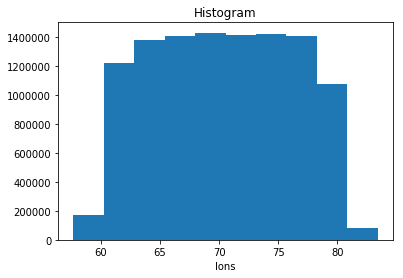

In [28]:
p_ds.lons.plot.hist();